In [1]:
############################################
# System initialization
############################################
import os 
import pickle
#
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
# for 正規分布: stats.norm
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.norm.html#scipy.stats.norm
from scipy import stats
# for シンプソン公式による数値積分: integrate.simps
from scipy import integrate
# for Γ(x) 関数
from math import gamma as gamma_func
#
%matplotlib inline
#
import numpy as np
#
# https://docs.pymc.io/
import pymc3 as pm
import theano
import time
from pymc3.backends.base import merge_traces
#
import datetime
#
# for reloading 
import importlib
#
print('numpy      Ver.', np.__version__)
print('matplotlib Ver.', mpl.__version__)
print('pymc3      Ver.', pm.__version__)
print('theano     Ver.', theano.__version__)
#
################################
# import iakai as ia
#
################################
import XANES20201116 as XA
#

numpy      Ver. 1.19.2
matplotlib Ver. 3.3.2
pymc3      Ver. 3.8
theano     Ver. 1.0.4


In [2]:
############################################
# Base configuration
############################################

######################################
# File path of the target data 
datafile = 'XANES_dumy01.txt'
#      
name_header   = 'Dumy'

######################################
# The target data 
XANES = np.loadtxt( datafile )
#
XANES_x = XANES[:,0]
XANES_y = XANES[:,1]

######################################
# Number of Gaussian peaks
GaussK = 5

######################################
# Base name and directory for saving
name_Base = name_header + ('-K%02d-v01' % GaussK)
######################################
file_path = name_Base + '/'
######################################
XA.makeFolder( file_path )

######################################
# Labels for graphs
label_x        = 'Energy (eV)'
label_y        = 'XANES intensity (arb. unit)'
label_title    = r'XANES / Dumy data'
#
label_material = r'Dumy'

######################################
# Basic configuration for pymc3
PYMC3chains = 4 # 16
print( 'PYMC3chains   = %d' % PYMC3chains )
PYMC3iters  = 2000 # 10000 # 2000 # 50000
print( 'PYMC3iters    = %d' % PYMC3iters )
PYMC3tunes  = 500 # 5000 # 2000  # 500  # 10000
print( 'PYMC3tunes    = %d' % PYMC3tunes )
PYMC3burns  = 500 # 2000  # 500  # 10000
print( 'PYMC3burns    = %d' % PYMC3burns )


Dumy-K05-v01/  is exist.
PYMC3chains   = 4
PYMC3iters    = 2000
PYMC3tunes    = 500
PYMC3burns    = 500


Data file = XANES_dumy01.txt
x         = 7.10500 - 7.14500 (mean = 7.12500, sd = 0.01160)
y         = 0.01351 - 1.55694 (mean = 0.60471, sd = 0.49558)
M0        = 0.02421
M1        = 7.13282
M2        = 0.00005
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-data.pdf


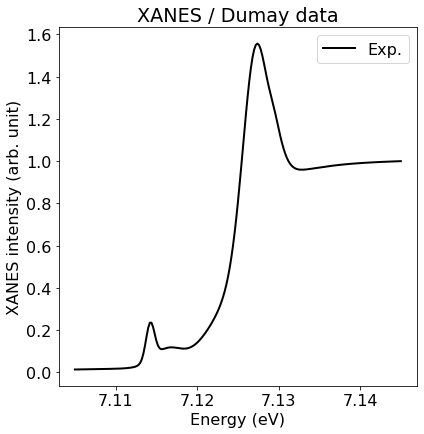

In [3]:
############################################
# Basic statistics and graph of the target data
############################################

(XANES_x_min, XANES_x_max, XANES_y_min, XANES_y_max, XANES_x_mean, XANES_x_sd, XANES_y_mean, XANES_y_sd) = XA.SpectralStats( XANES_x, XANES_y )
(XANES_M0, XANES_M1, XANES_M2) = XA.SpectralMoments( XANES_x, XANES_y )
#
print( 'Data file = %s' % datafile )
print( 'x         = %.5f - %.5f (mean = %.5f, sd = %.5f)' % (XANES_x_min, XANES_x_max, XANES_x_mean, XANES_x_sd) )
print( 'y         = %.5f - %.5f (mean = %.5f, sd = %.5f)' % (XANES_y_min, XANES_y_max, XANES_y_mean, XANES_y_sd) )
print( 'M0        = %.5f' % XANES_M0 )
print( 'M1        = %.5f' % XANES_M1 )
print( 'M2        = %.5f' % XANES_M2 )
#
######################################
fig = XA.Grf1( XANES_x, XANES_y, title = label_title, xlabel =label_x, ylabel = label_y )
#
file_fpath = file_path + name_Base + '-data.pdf'
XA.GrfPdfPages( file_fpath, fig )

In [4]:
############################################
# Prior probability Configuration
############################################

######################################
# Definitions of prior probability
#
# [ XA.PriorFunc_????, arg1, arg2, arg3, ... ]
#
# XA.PriorFunc_Unknown                = -1
# XA.PriorFunc_Uniform                = 0 # arg1 = lower, arg2 = upper
# XA.PriorFunc_Norm                   = 1 # arg1 = mean,  arg2 = sd
# XA.PriorFunc_Gamma                  = 2 # arg1 = alpha, arg2 = beta
# XA.PriorFunc_Beta                   = 3 # arg1 = alpha, arg2 = beta
# XA.PriorFunc_TruncatedNorm          = 4 # arg1 = mean,  arg2 = sd, arg3 = lower, arg4 = upper
# XA.PriorFunc_TruncatedNorm_sd_ratio = 5 # arg1 = mean,  arg2 = sd, arg3 = ratio
#
#----------
# RSMD
prior_RMSD      = [ XA.PriorFunc_Uniform, 0.0,    0.2    ]  # arg1 = lower, arg2 = upper
# XA.PriorTrial( prior_RMSD, None )
#----------
# STEParctanBL(x,H, E0, Gamma, y0)
prior_atanH     = [ XA.PriorFunc_Gamma,   5.0,  6.0    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_atanH, None )
#
prior_atanE0    = [ XA.PriorFunc_Uniform, 7.12, 7.14 ]  # arg1 = lower, arg2 = upper
# XA.PriorTrial( prior_atanE0, None )
#
prior_atanGamma = [ XA.PriorFunc_Gamma,   10.0,  5000.0    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_atanGamma, 2E-3 )
#
prior_y0        = [ XA.PriorFunc_Norm,    0.0,  5.0E-2 ]  # arg1 = mean,  arg2 = sd
# XA.PriorTrial( prior_y0, 0.0 )
#
#----------
# Gauss
prior_GaussF    = [ XA.PriorFunc_Gamma,   1.0,    15    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_GaussF, 0.1 )
#
prior_GaussE    = [ XA.PriorFunc_Uniform, 7.105, 7.145 ]  # arg1 = lower, arg2 = upper
# XA.PriorTrial( prior_GaussE, 7.13)
#
prior_GaussW    = [ XA.PriorFunc_Gamma,    2.0,    50    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_GaussW, 0.008 )
#

In [5]:
##########################################
# XA.PriorTrial( prior_def, ref_value ):
#   Drawing prior prob. for testing the prior probability 
##########################################
# prior_atanGamma = [ XA.PriorFunc_Gamma,   10.0,  5000.0    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_atanGamma, 2E-3 )
#
# prior_GaussF    = [ XA.PriorFunc_Gamma,   1.0,    15    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_GaussF, 0.1 )
#
# prior_GaussW    = [ XA.PriorFunc_Gamma,    2.0,    50    ]  # arg1 = alpha, arg2 = beta
# XA.PriorTrial( prior_GaussW, 0.008 )
#

In [6]:
############################################
# Fitting function and parameter Configuration
############################################
# FitFunc :=
# [
#   (0) name,       string used as the identifier
#   (1) Params,     [ Param1, Param2, ... ]
# ]
# 
# Param :=
# [ 
#   (0) name,       string used as the identifier in pymc3
#   (1) expresson,  string for the tile of abscissa in the graphs of prior/posterior probability
#   (2) ref_value,  [label_str, numeric ]: string of label and numeric for reference value / None
#   (3) prior_def,  definition for the prior probability
#   (4) trace,      the selected trace
#   (5) mean_value, the mean value of the trace
#   (6) sd,         the sandard deviation of the trace
#   (7) histgram.   [bins, hists], the histgram of the trace
#   (8) MLE_index,  the trace index having maximum likelihood (ML estimation)
#   (9) MLE_value,  the value at the MLE_index
# ]

############################################
# rmsd: It is not a fitting function, it is only for the variable of 'rmsd'
############################################
RMSD_param = [ 'rmsd',      r'RMSD',          ['ref',0.1], prior_RMSD, None, None, None, None, None, None ]

############################################
# Absorption step and baseline function
############################################
STEP_Func = [
    [ 'STEP', #   (0) name,       string used as the identifier
     [        #   (1) Params,     [ Param1, Param2, ... ]
         # STEParctanBL(x,H, E0, Gamma, y0)
         [ 'atanH',     r'atan-$H$',      None, prior_atanH,       None, None, None, None, None, None ],
         [ 'atanE0',    r'atan-$E_{0}$',  None, prior_atanE0,      None, None, None, None, None, None ],
         [ 'atanGamma', r'atan-$\Gamma$', None, prior_atanGamma,   None, None, None, None, None, None ],
         [ 'y0',        r'$y_{0}$',       None, prior_y0,          None, None, None, None, None, None ]
     ]
    ]
]

############################################
# Gaussian functions
############################################
Gauss_Funcs = []
#
for gauss_k in range(GaussK):
    #
    k_ = gauss_k + 1
    #
    func_name_ = 'Gauss%02d' % k_
    #
    param_base_name_       = 'Gauss%02d'  % k_
    param_base_expression_ = 'Gauss%02d-' % k_
    #
    # parameters for Gaussian
    #
    param_ = []
    #
    # Intensity (integrated)
    #
    param_.append( [
        param_base_name_       + 'F', #   name
        param_base_expression_ + 'F', #   expresson
        None,                         #   ref_value
        prior_GaussF,                 #   prior_def
        None, None, None, None, None, None
    ] )
    #
    # Transition energy
    #
    param_.append( [
        param_base_name_       + 'E', #   name
        param_base_expression_ + 'E', #   expresson
        None,                         #   ref_value
        prior_GaussE,                 #   prior_def
        None, None, None, None, None, None
    ] )
    #
    # Width
    #
    param_.append( [
        param_base_name_       + 'W', #   name
        param_base_expression_ + 'W', #   expresson
        None,                         #   ref_value
        prior_GaussW,                 #   prior_def
        None, None, None, None, None, None
    ])
    #
    # appending one Gaussian component
    #
    Gauss_Funcs.append( [ func_name_, param_ ] )

############################################
# All functions 
############################################
Fit_Funcs = STEP_Func 
Fit_Funcs.extend( Gauss_Funcs )
#
#  Fit_Funcs

Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-rmsd.pdf
Number of the fitting functions = 6
------------
STEP
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-STEP.pdf
------------
Gauss01
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-Gauss01.pdf
------------
Gauss02
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-Gauss02.pdf
------------
Gauss03
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-Gauss03.pdf
------------
Gauss04
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-Gauss04.pdf
------------
Gauss05
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-prior-Gauss05.pdf


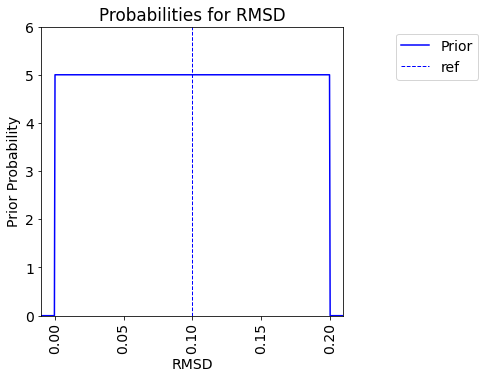

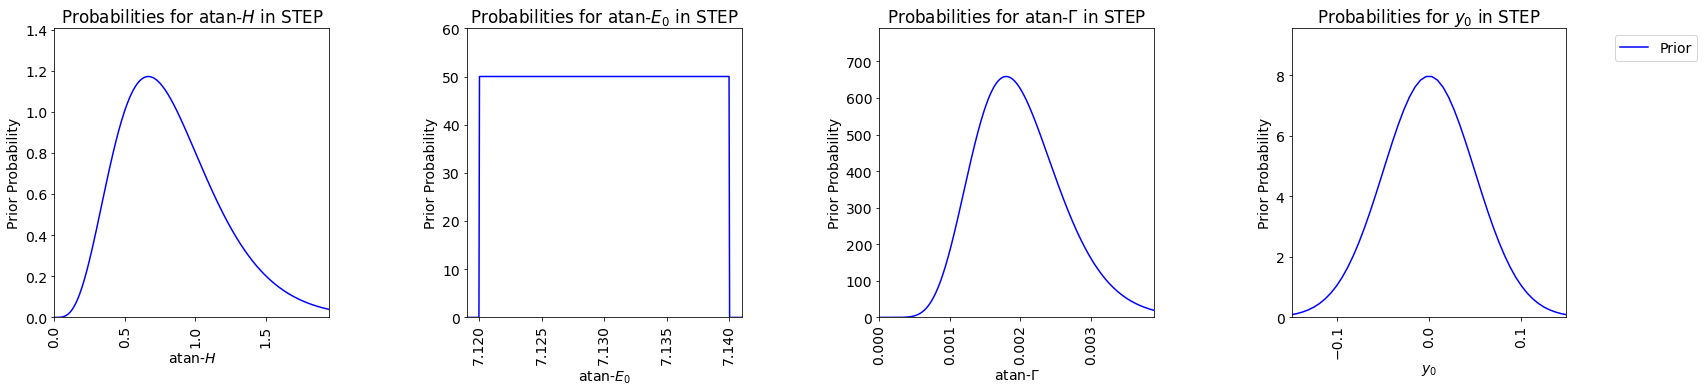

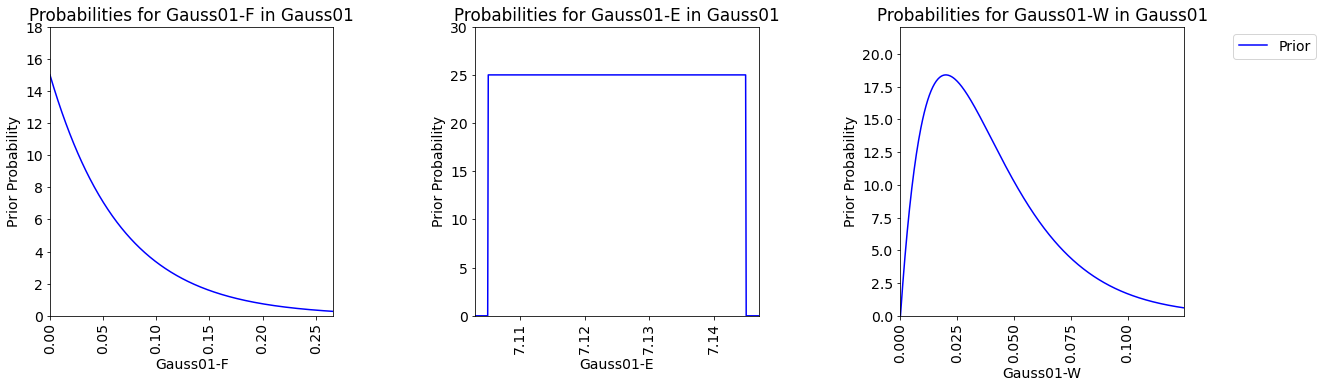

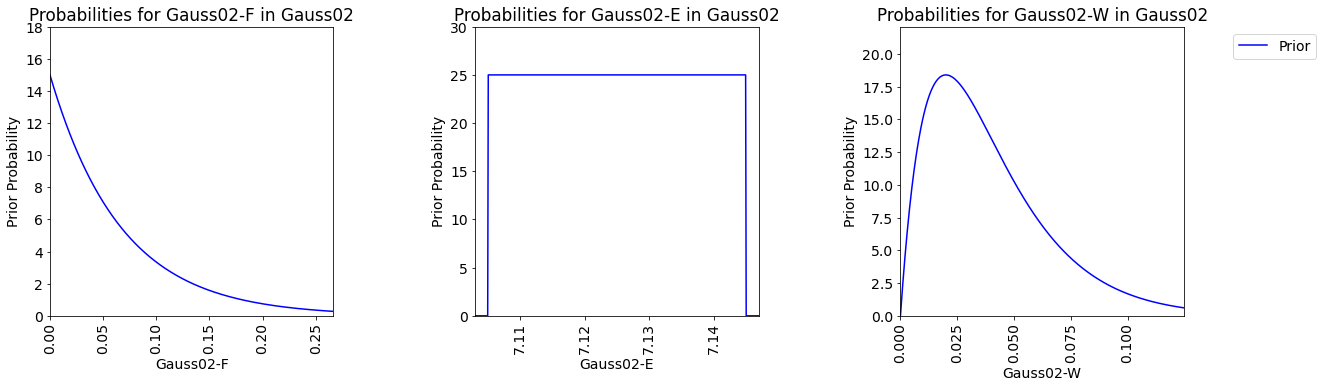

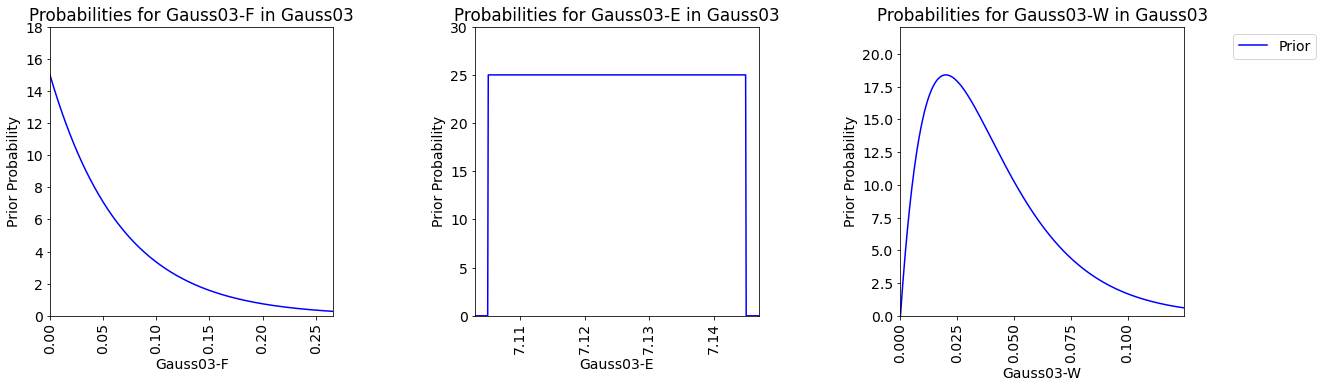

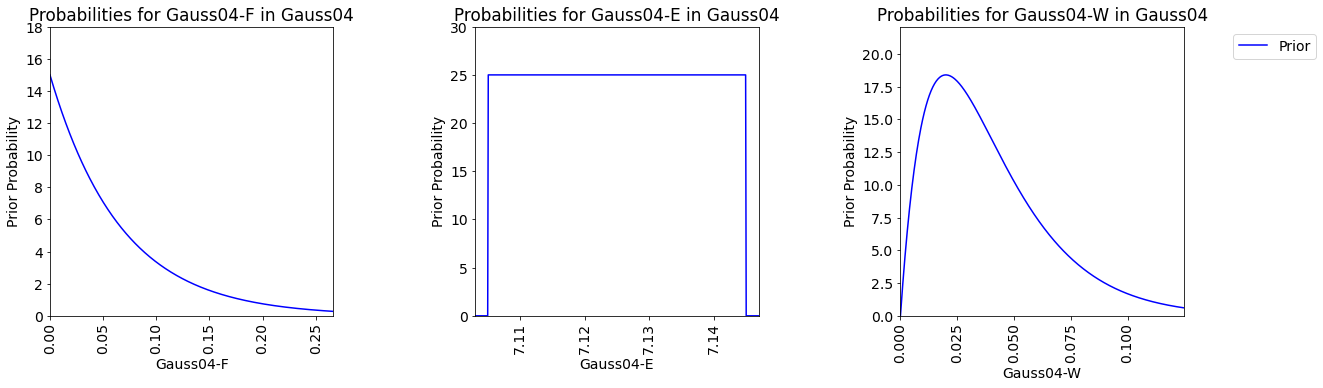

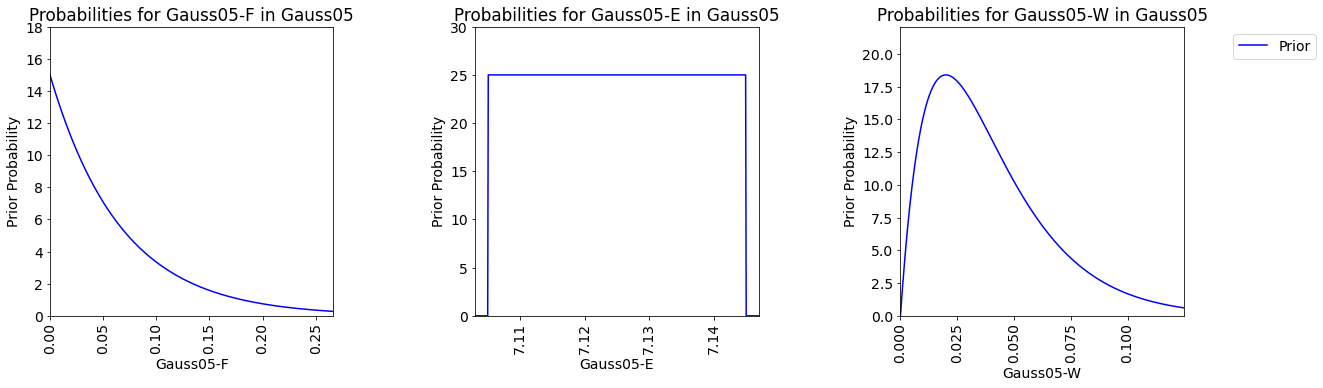

In [7]:
############################################
# Graphs of prior probabilties
############################################
#
# rmsd
#
pdf_name   = name_Base + '-prior-rmsd.pdf'
file_fpath = file_path + pdf_name
#
fig = XA.GrfParamsProbabilities01( RMSD_param )
#
XA.GrfPdfPages( file_fpath, fig )        
#
# Params in Fit_Funcs
#
print( 'Number of the fitting functions = %d' % len(Fit_Funcs) )
#
for fit_func in Fit_Funcs:
    #
    func_name_   = fit_func[ 0 ]
    func_params_ = fit_func[ 1 ]
    #
    print( '------------' )
    print( '%s' %  func_name_ )
    # print( '%s = %d' % (func_name_, len(func_params_) ) )
    #
    pdf_name   = name_Base + '-prior-' + func_name_ + '.pdf'
    file_fpath = file_path + pdf_name
    #
    fig = XA.GrfFuncProbabilities01( fit_func )
    #
    XA.GrfPdfPages( file_fpath, fig )        


In [8]:
############################################
# Definition of Model
############################################
# Since this function is used in the sampling of pymc3,
# it should be defined with a simple style for speed up.
def PhysicalModel(x, params ):
    #
    # The parameters in the params_ are registered according to the order of 
    # the registered functions (Fit_Funcs) and their variables, 
    # and the params_ is passed directly to the physical model.
    # Therefore, in the physical model, we have to use these parameters by 
    # the ordered indexes.
    #
    Reg_ = XA.STEParctanBL(x, params[0], params[1], params[2], params[3])
    #
    for k_ in range(GaussK):
        idx_ = 4 + k_ * 3
        Gauss_ = XA.Gaussian(x, params[idx_], params[idx_+1], params[idx_+2])
        Reg_ = Reg_ + Gauss_
    #
    return Reg_

######################################
# On the other hand, this function is used to 
# make the regression and components data.
def PhysicalModelReg(x, params ):
    #
    # The parameters in the params_ are registered according to the order of 
    # the registered functions (Fit_Funcs) and their variables, 
    # and the params_ is passed directly to the physical model.
    # Therefore, in the physical model, we have to use these parameters by 
    # the ordered indexes.
    #
    Comps = []
    #
    Spec_ = XA.STEParctanBL(x, params[0], params[1], params[2], params[3])
    #
    Comps.append( [ 'STEP', Spec_ ] )
    Reg = Spec_
    #
    for k_ in range(GaussK):
        idx_ = 4 + k_ * 3
        Spec_ = XA.Gaussian(x, params[idx_], params[idx_+1], params[idx_+2])
        #
        Comps.append( [ 'Gauss%02d' % (k_+1), Spec_ ] )
        Reg = Reg + Spec_
    #
    return (Reg, Comps)

MCMC_findMAP_NUTS_v6: iters=2000, chains=4, burns=500, tunes=500
rmsd      : Uniform( lower=0, upper=0.2 )
atanH     : Gamma( alpha=5, beta=6 )
atanE0    : Uniform( lower=7.12, upper=7.14 )
atanGamma : Gamma( alpha=10, beta=5000 )
y0        : Normal( mu=0, sd=0.05 )
Gauss01F  : Gamma( alpha=1, beta=15 )
Gauss01E  : Uniform( lower=7.105, upper=7.145 )
Gauss01W  : Gamma( alpha=2, beta=50 )
Gauss02F  : Gamma( alpha=1, beta=15 )
Gauss02E  : Uniform( lower=7.105, upper=7.145 )
Gauss02W  : Gamma( alpha=2, beta=50 )
Gauss03F  : Gamma( alpha=1, beta=15 )
Gauss03E  : Uniform( lower=7.105, upper=7.145 )
Gauss03W  : Gamma( alpha=2, beta=50 )
Gauss04F  : Gamma( alpha=1, beta=15 )
Gauss04E  : Uniform( lower=7.105, upper=7.145 )
Gauss04W  : Gamma( alpha=2, beta=50 )
Gauss05F  : Gamma( alpha=1, beta=15 )
Gauss05E  : Uniform( lower=7.105, upper=7.145 )
Gauss05W  : Gamma( alpha=2, beta=50 )


logp = 458.47, ||grad|| = 1.9724: 100%|██████████| 127/127 [00:00<00:00, 968.93it/s]  
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Gauss05W, Gauss05E, Gauss05F, Gauss04W, Gauss04E, Gauss04F, Gauss03W, Gauss03E, Gauss03F, Gauss02W, Gauss02E, Gauss02F, Gauss01W, Gauss01E, Gauss01F, y0, atanGamma, atanE0, atanH, rmsd]
Sampling 4 chains, 0 divergences: 100%|██████████| 12000/12000 [21:04<00:00,  9.49draws/s]
The acceptance probability does not match the target. It is 0.9417478614727289, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.9600545980036884, but should be close to 0.8. Try to increase the number of tuning steps.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


Saving pickle file = Dumy-K05-v01/Dumy-K05-v01-trace1116182157.pkl
Trace has been saved to Dumy-K05-v01/Dumy-K05-v01-trace1116182157.pkl


C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has 

C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  warnings.warn(
C:\wsci\anaconda3\envs\pymc3\lib\site-packages\arviz\plots\backends\matplotlib\distplot.py:36: UserWarning: Argument backend_kwargs has 

Traceplot has been saved to Dumy-K05-v01/Dumy-K05-v01-trace1116182157.pdf


,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
y0,-0.005,0.007,-0.014,0.003,0.003,0.003,4.0,4.0,5.0,28.0,2.87
rmsd,0.001,0.001,0.000,0.003,0.000,0.000,4.0,4.0,5.0,28.0,2.66
atanH,1.036,0.020,1.019,1.070,0.010,0.007,4.0,4.0,5.0,29.0,2.12
atanE0,7.130,0.002,7.127,7.132,0.001,0.001,4.0,4.0,5.0,29.0,2.84
atanGamma,0.003,0.001,0.002,0.004,0.000,0.000,4.0,4.0,5.0,28.0,2.84
Gauss01F,0.002,0.002,0.000,0.005,0.001,0.001,4.0,4.0,5.0,27.0,2.85
Gauss01E,7.126,0.006,7.116,7.130,0.003,0.002,4.0,4.0,5.0,27.0,2.84
Gauss01W,0.004,0.001,0.002,0.006,0.001,0.001,4.0,4.0,5.0,26.0,2.86
Gauss02F,0.000,0.000,0.000,0.000,0.000,0.000,4.0,4.0,5.0,29.0,2.28
Gauss02E,7.115,0.001,7.114,7.116,0.000,0.000,4.0,4.0,7.0,27.0,1.99


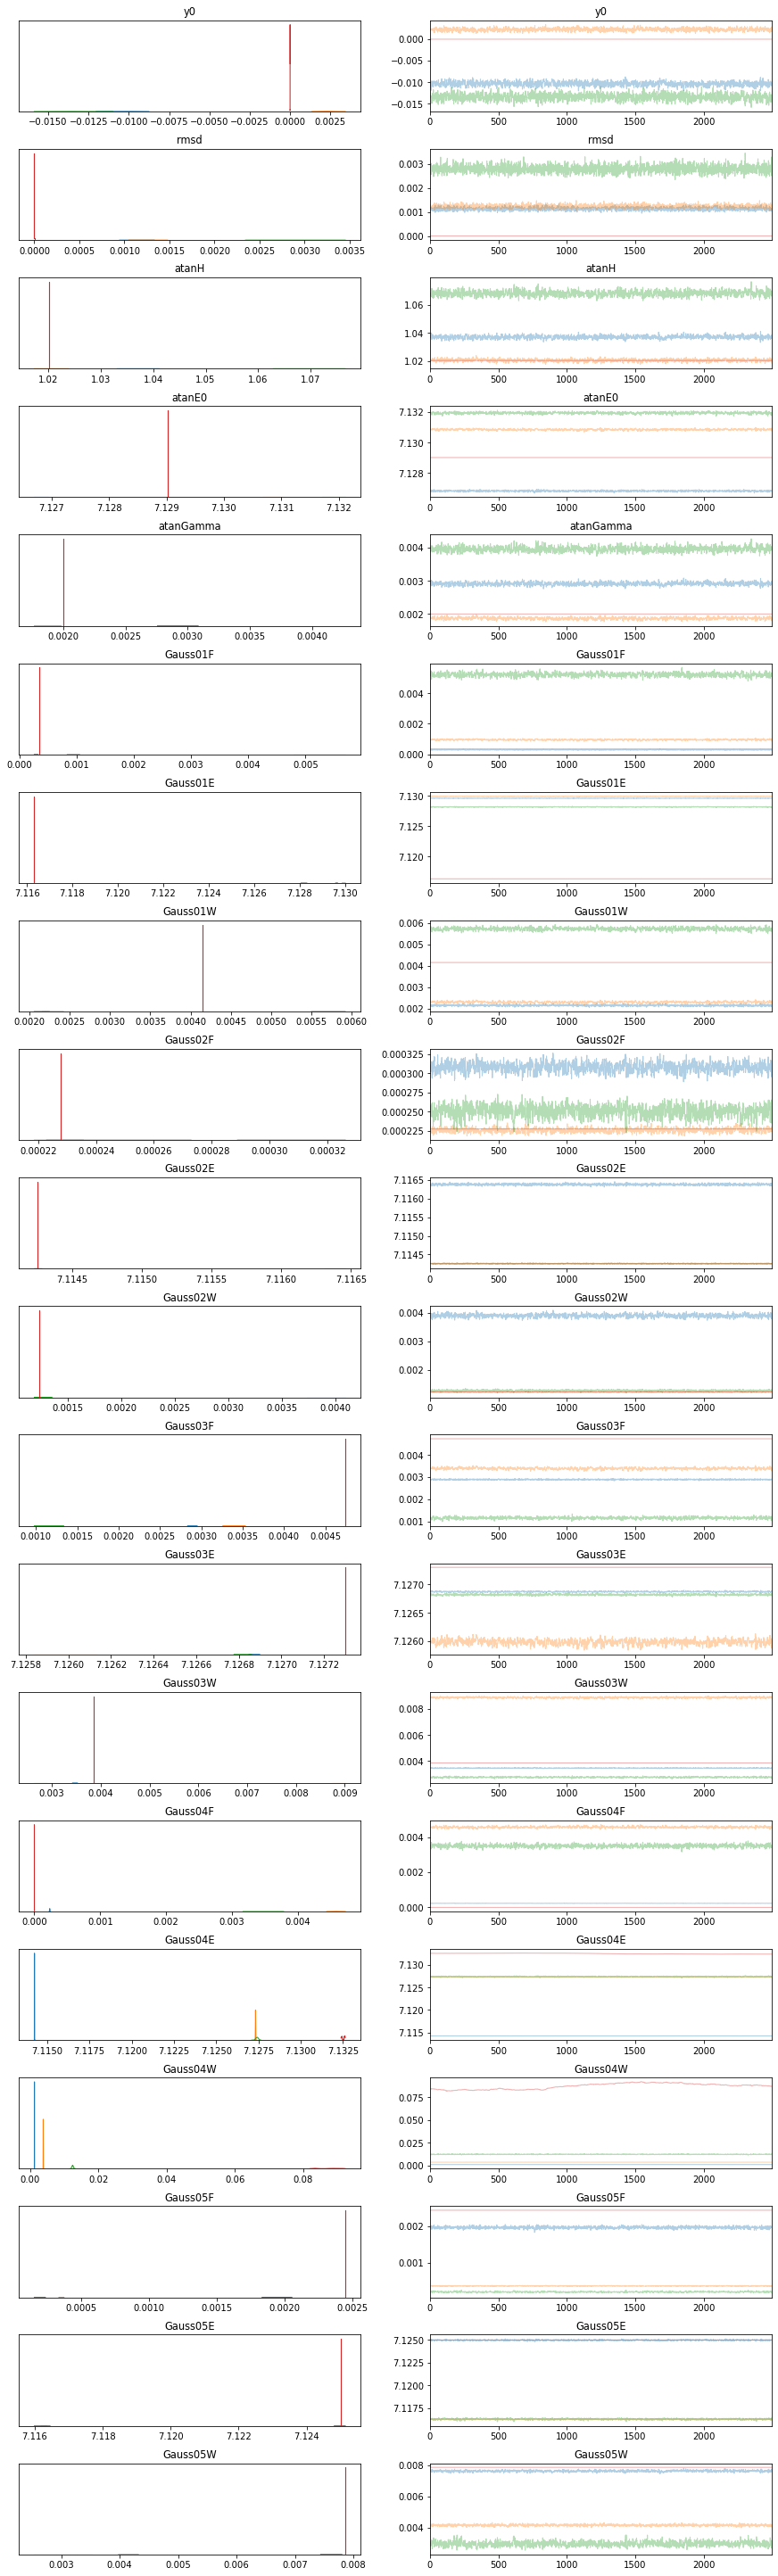

In [9]:
######################################
trace_ = XA.MCMC_findMAP_NUTS_v6( XANES_x, XANES_y, PhysicalModel, RMSD_param, Fit_Funcs, \
                                  iters=PYMC3iters, chains=PYMC3chains, burns=PYMC3burns, tunes=PYMC3tunes )
#
# When more than one spectral component with the same prior probability 
# and spectral function are included, the assignments of their spectral 
# components are exchanged randomly in each of the parallel computing 
# chains, so that, the warning of "The rhat statistic is larger than ...
# The sampler did not converge." arises.
# 
# However, that is a natural result. So that, we employ the trace of 
# the chain with the smallest mean value of rmsd among the chains and 
# perform statistical processing.
#
# 
####################### 
# Saving the trace to pickle file
dt_now = datetime.datetime.now()
str_dt_now = dt_now.strftime('%m%d%H%M%S')
trace_name = name_Base + '-trace' + str_dt_now
#
pkl_fname  = trace_name + '.pkl'
pkl_fpath  = file_path + pkl_fname
XA.PickleTrace( pkl_fpath, trace_ )
print( 'Trace has been saved to %s' % pkl_fpath )
#
####################### 
# traceplot
pm.traceplot( trace_ )
pdf_fpath = file_path +trace_name + '.pdf'
plt.savefig( pdf_fpath )
print( 'Traceplot has been saved to %s' % pdf_fpath )

####################### 
# summary
pm.summary( trace_ )


In [10]:
######################################
# When retry the analysis based on the same sampling result,
# please reload the pklfile by comment-out the following lines.
######################################
# pkl_fpath  = 'Dumy-K05-v01/Dumy-K05-v01-trace1116174732.pkl'
# trace_ = pickle.load( open( pkl_fpath, mode='rb') )

         chain= 0, rmsd_mean=1.125152E-03
         chain= 1, rmsd_mean=1.235221E-03
         chain= 2, rmsd_mean=2.793491E-03
         chain= 3, rmsd_mean=2.972982E-07
-------------
Selected chain= 3, rmsd_mean=2.972982E-07
-------------
RMSD: mean      = 2.972982E-07
RMSD: sd        = 1.609550E-08
RMSD: MLE_index = 176
RMSD: MLE_value = 2.506907E-07
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-rmsd.pdf
--------------------
MLE_index       = 176


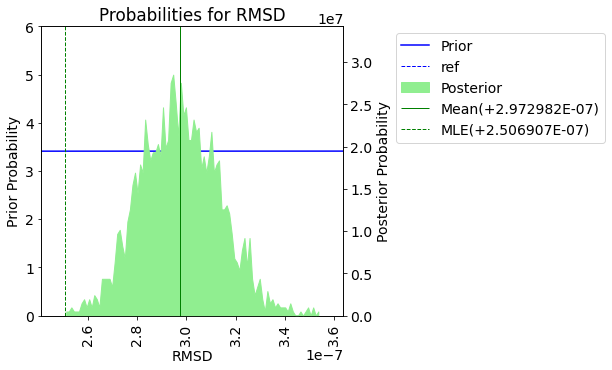

In [11]:
######################################
# Selection of chain, which has the smallest mean value of rmsd 
# and statistical analysis of the rmds param.
#------------------
# When more than one spectral component with the same prior probability 
# and spectral function are included, the assignments of their spectral 
# components are exchanged randomly in each of the parallel computing 
# chains, so that, the warning of "The rhat statistic is larger than ...
# The sampler did not converge." arises.
# 
# However, that is a natural result. So that, we employ the trace of 
# the chain with the smallest mean value of rmsd among the chains and 
# perform statistical processing.
#
# An alternative selection method would be according to the criterion 
# of maximum likelihood estimation / MAP and select at the rmsd minimum 
# / the posterior probability maximum.
#
#######################################
chain_selected, MLE_Index = XA.SelectChain_StatsRMSD( trace_, RMSD_param, PYMC3chains, PYMC3burns )
######################################
# RMSD posterior
#
pdf_name   = name_Base + '-posterior-rmsd.pdf'
file_fpath = file_path + pdf_name
#
fig = XA.GrfParamsProbabilities01( RMSD_param )
#
XA.GrfPdfPages( file_fpath, fig )        

######################################
# Index in trace for the Maximum likelihood estimation
print( '--------------------' )
print( 'MLE_index       = %d' % MLE_Index )

In [12]:
######################################
# Statistical analysis of the params in fit_funcs.
######################################
reports = XA.Stats_fit_funcs( trace_, Fit_Funcs, chain_selected, MLE_Index, PYMC3burns )

Number of the fitting functions = 6
---------- Mean values ---------
# ['STEP',
#   [
#     ['atanH'        , ['mean', +1.020297E+00] ]
#     ['atanE0'       , ['mean', +7.129020E+00] ]
#     ['atanGamma'    , ['mean', +2.000004E-03] ]
#     ['y0'           , ['mean', -1.133221E-06] ]
#   ]
# ]
# ['Gauss01',
#   [
#     ['Gauss01F'     , ['mean', +3.554558E-04] ]
#     ['Gauss01E'     , ['mean', +7.116330E+00] ]
#     ['Gauss01W'     , ['mean', +4.149987E-03] ]
#   ]
# ]
# ['Gauss02',
#   [
#     ['Gauss02F'     , ['mean', +2.277572E-04] ]
#     ['Gauss02E'     , ['mean', +7.114253E+00] ]
#     ['Gauss02W'     , ['mean', +1.232004E-03] ]
#   ]
# ]
# ['Gauss03',
#   [
#     ['Gauss03F'     , ['mean', +4.739447E-03] ]
#     ['Gauss03E'     , ['mean', +7.127300E+00] ]
#     ['Gauss03W'     , ['mean', +3.860002E-03] ]
#   ]
# ]
# ['Gauss04',
#   [
#     ['Gauss04F'     , ['mean', +1.332043E-07] ]
#     ['Gauss04E'     , ['mean', +7.132494E+00] ]
#     ['Gauss04W'     , ['mean', +8.834178E-

Number of the fitting functions = 6
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-STEP.pdf
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-Gauss01.pdf
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-Gauss02.pdf
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-Gauss03.pdf
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-Gauss04.pdf
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-posterior-Gauss05.pdf


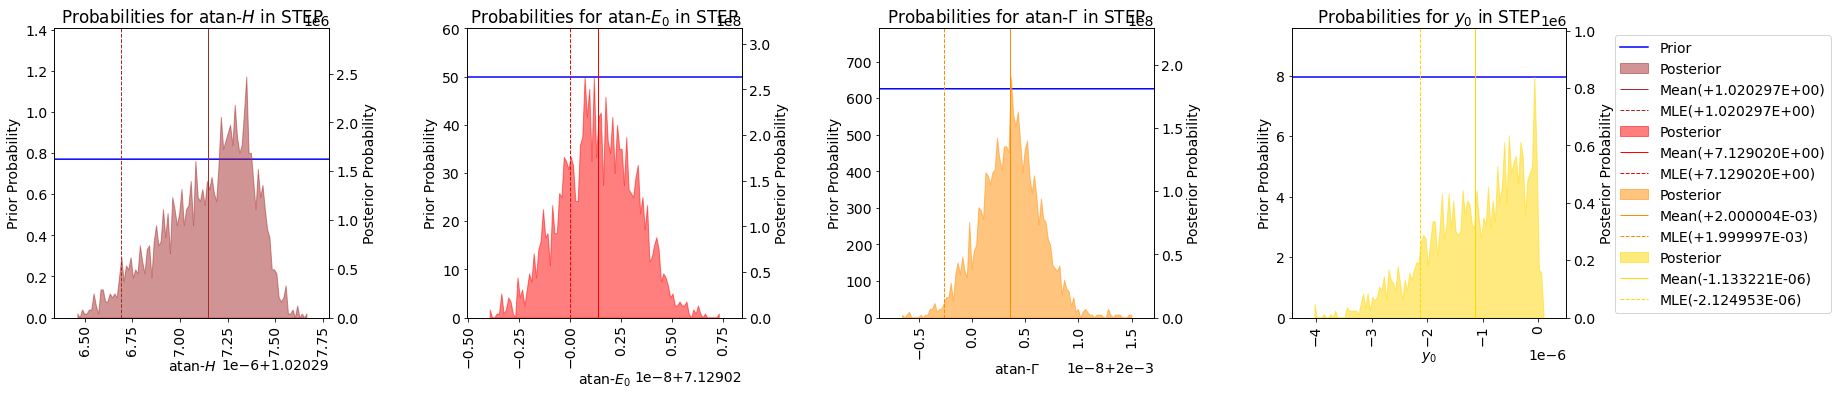

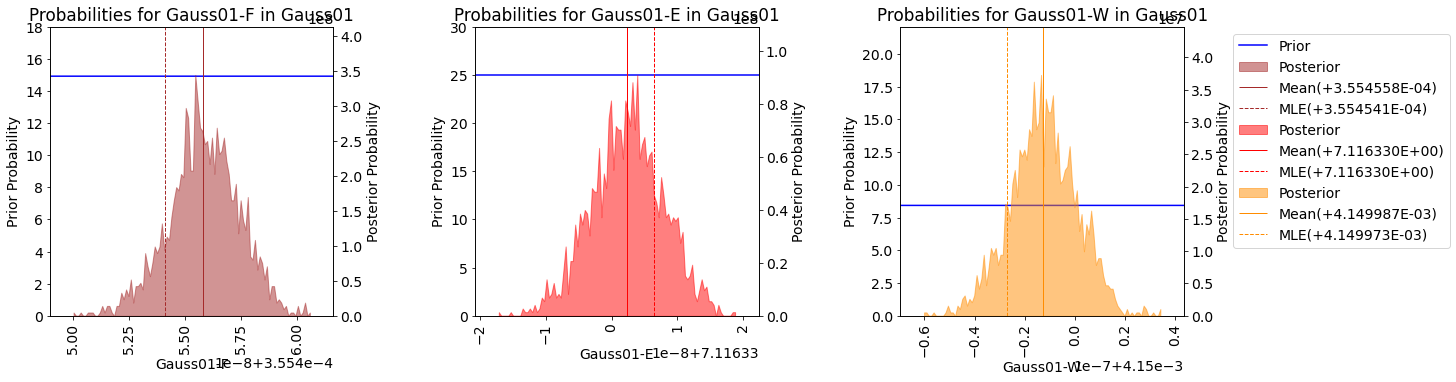

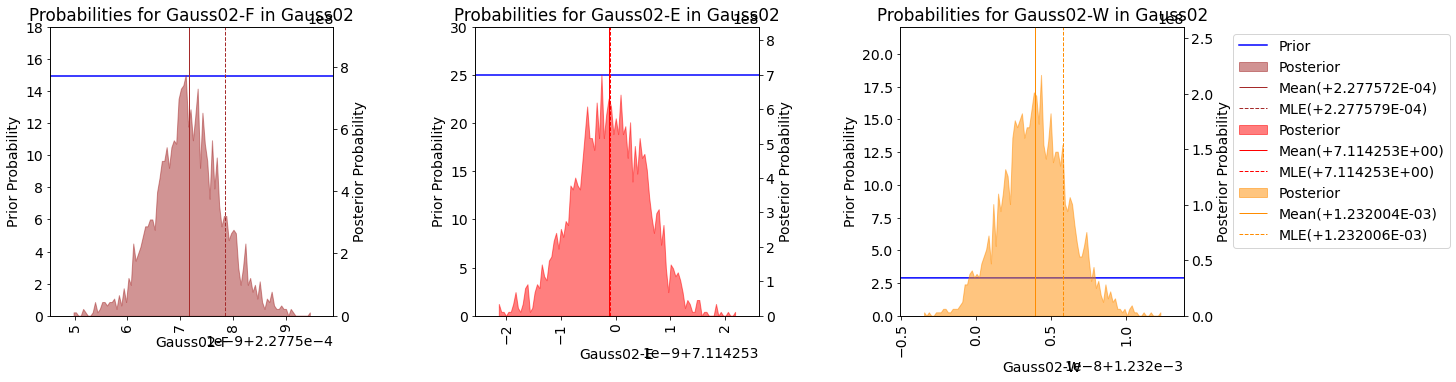

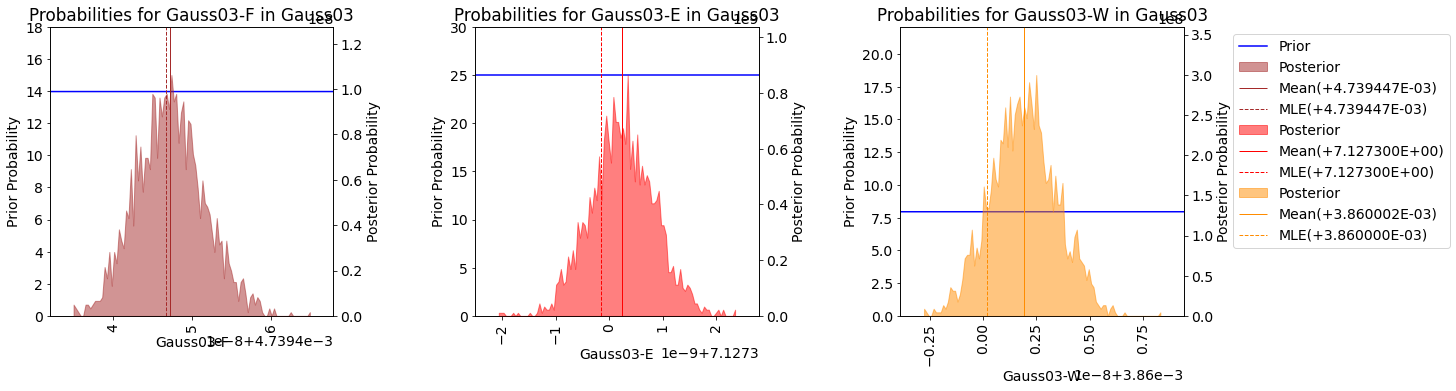

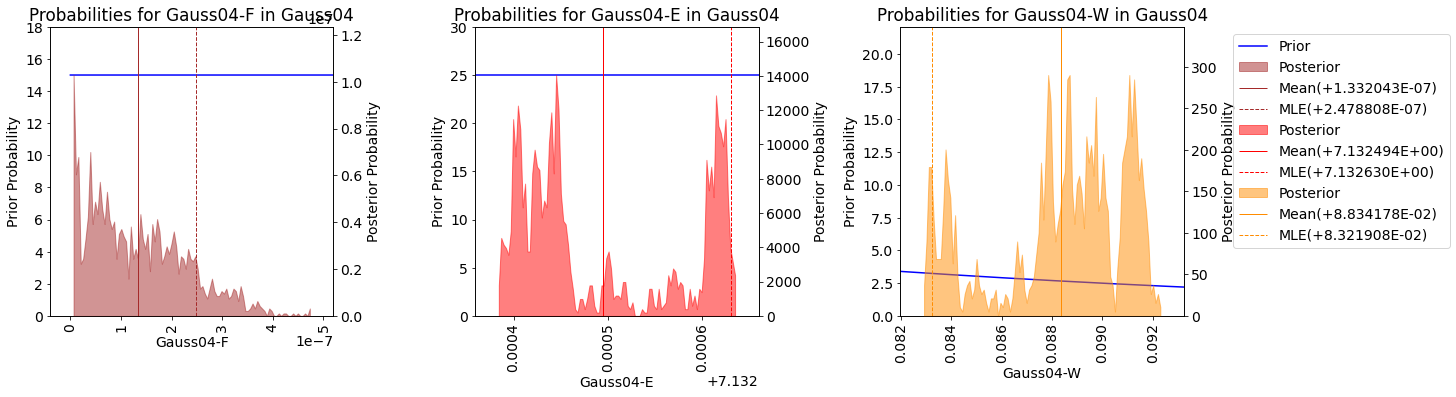

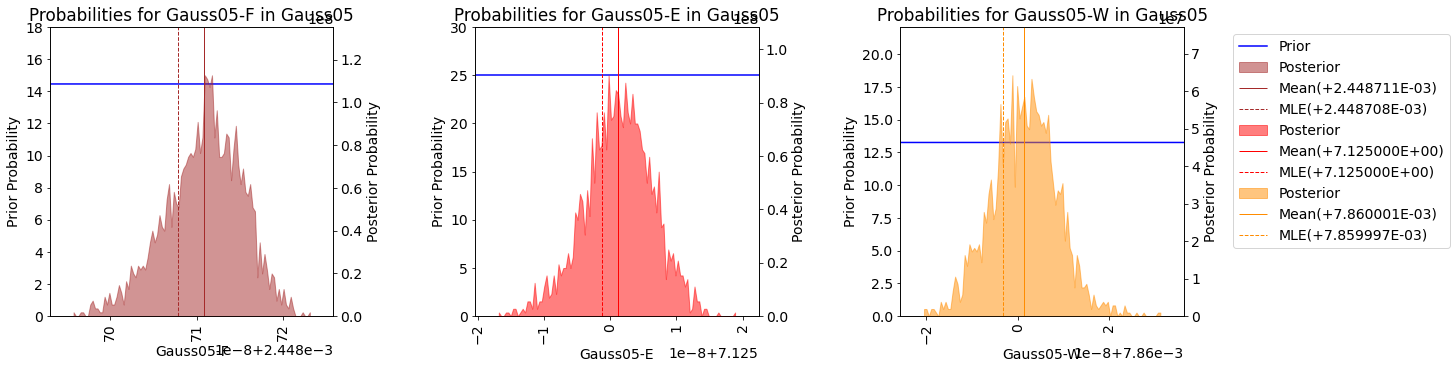

In [13]:
######################################
# Params in Fit_Funcs
#
print( 'Number of the fitting functions = %d' % len(Fit_Funcs) )
#
for fit_func in Fit_Funcs:
    #
    func_name_   = fit_func[ 0 ]
    #
    pdf_name   = name_Base + '-posterior-' + func_name_ + '.pdf'
    file_fpath = file_path + pdf_name
    #
    # fig = GrfFuncProbabilities01( fit_func, xlim_posterior = False)
    fig = XA.GrfFuncProbabilities01( fit_func )
    #
    XA.GrfPdfPages( file_fpath, fig )        


------------
Criterion for Regression: Mean
----------------------
Func:Param           =
STEP:atanH           = +1.020297E+00 (Mean)
STEP:atanE0          = +7.129020E+00 (Mean)
STEP:atanGamma       = +2.000004E-03 (Mean)
STEP:y0              = -1.133221E-06 (Mean)
Gauss01:Gauss01F     = +3.554558E-04 (Mean)
Gauss01:Gauss01E     = +7.116330E+00 (Mean)
Gauss01:Gauss01W     = +4.149987E-03 (Mean)
Gauss02:Gauss02F     = +2.277572E-04 (Mean)
Gauss02:Gauss02E     = +7.114253E+00 (Mean)
Gauss02:Gauss02W     = +1.232004E-03 (Mean)
Gauss03:Gauss03F     = +4.739447E-03 (Mean)
Gauss03:Gauss03E     = +7.127300E+00 (Mean)
Gauss03:Gauss03W     = +3.860002E-03 (Mean)
Gauss04:Gauss04F     = +1.332043E-07 (Mean)
Gauss04:Gauss04E     = +7.132494E+00 (Mean)
Gauss04:Gauss04W     = +8.834178E-02 (Mean)
Gauss05:Gauss05F     = +2.448711E-03 (Mean)
Gauss05:Gauss05E     = +7.125000E+00 (Mean)
Gauss05:Gauss05W     = +7.860001E-03 (Mean)
Saving GrfPdfPages = Dumy-K05-v01/Dumy-K05-v01-Regression-Mean.pdf
-------

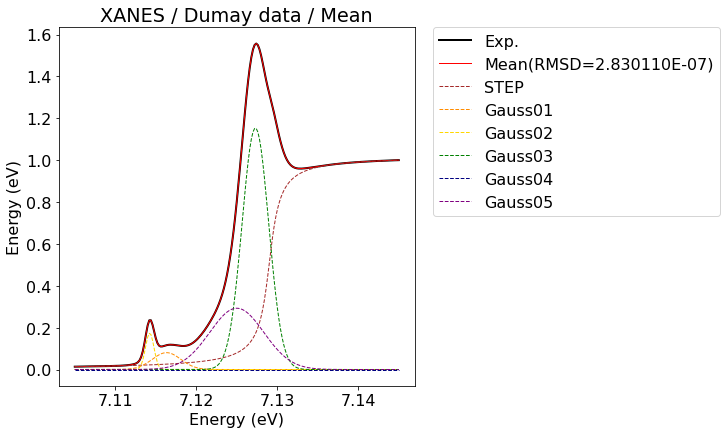

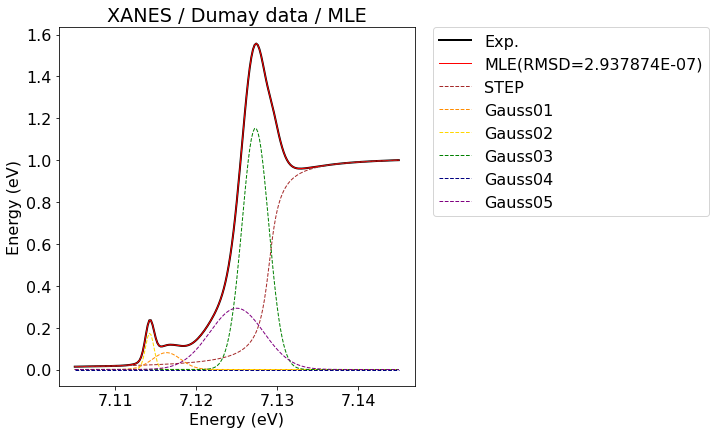

In [14]:
######################################
# Regression
######################################
#
# by Mean values
#
print('------------')
reg_rmsd_mean, fig = XA.GrfRegression( XANES_x, XANES_y, PhysicalModelReg, Fit_Funcs, label_title, xlabel=label_x, ylabel=label_x, \
                                       regcriterion=XA.RegCriterion_Mean )
#
fname_mean      = name_Base + '-Regression-Mean.pdf'
file_fpath_mean = file_path + fname_mean
XA.GrfPdfPages( file_fpath_mean, fig )
#
# by MLE values
#
print('------------')
reg_rmsd_MLE, fig = XA.GrfRegression( XANES_x, XANES_y, PhysicalModelReg, Fit_Funcs, label_title, xlabel=label_x, ylabel=label_x, \
                                      regcriterion=XA.RegCriterion_MLE )
#
fname_MLE      = name_Base + '-Regression-MLE.pdf'
file_fpath_MLE = file_path + fname_MLE
XA.GrfPdfPages( file_fpath_MLE, fig )

In [15]:
######################################
# Reporting by Email
######################################
#
reports.append( '-------------------' )
#
if reg_rmsd_mean <= reg_rmsd_MLE:
    reports.append( 'reg_rmsd_mean(%.6E) <= reg_rmsd_MLE(%.6E)' % (reg_rmsd_mean, reg_rmsd_MLE) )
    fname = fname_mean
    file_fpath = file_fpath_mean
else:
    reports.append( 'reg_rmsd_mean(%.6E) > reg_rmsd_MLE(%.6E)' % (reg_rmsd_mean, reg_rmsd_MLE) )
    fname = fname_MLE
    file_fpath = file_fpath_MLE
#
email_header = '%s / %s ' % (name_Base, fname )
XA.Email_ReportPDF( email_header, reports, fname, file_fpath, 'iakai@localhost', 'iakai@kumamoto-u.ac.jp' )

-------------------
Func:Param           =      mean     +/-      sd      ,     MLE       
STEP:atanH           = +1.020297E+00 +/- +2.303858E-07, +1.020297E+00 
STEP:atanE0          = +7.129020E+00 +/- +1.809573E-09, +7.129020E+00 
STEP:atanGamma       = +2.000004E-03 +/- +2.818781E-09, +1.999997E-03 
STEP:y0              = -1.133221E-06 +/- +8.300490E-07, -2.124953E-06 
Gauss01:Gauss01F     = +3.554558E-04 +/- +1.559971E-09, +3.554541E-04 
Gauss01:Gauss01E     = +7.116330E+00 +/- +5.451691E-09, +7.116330E+00 
Gauss01:Gauss01W     = +4.149987E-03 +/- +1.330698E-08, +4.149973E-03 
Gauss02:Gauss02F     = +2.277572E-04 +/- +6.407865E-10, +2.277579E-04 
Gauss02:Gauss02E     = +7.114253E+00 +/- +6.607651E-10, +7.114253E+00 
Gauss02:Gauss02W     = +1.232004E-03 +/- +2.216113E-09, +1.232006E-03 
Gauss03:Gauss03F     = +4.739447E-03 +/- +4.299753E-09, +4.739447E-03 
Gauss03:Gauss03E     = +7.127300E+00 +/- +5.998268E-10, +7.127300E+00 
Gauss03:Gauss03W     = +3.860002E-03 +/- +1.533451E-09, +